In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
#贝叶斯优化调参器
from bayes_opt import BayesianOptimization
import lightgbm as lgb
import os, sys


/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Load data 
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')

## <span style='color:blue;background:yellow'>Data Cleaning and Preprocessing


In [3]:
train.nunique()

RowId                      857409
IntersectionId               2539
Latitude                     4505
Longitude                    4541
EntryStreetName              1707
ExitStreetName               1693
EntryHeading                    8
ExitHeading                     8
Hour                           24
Weekend                         2
Month                           9
Path                        15111
TotalTimeStopped_p20          172
TotalTimeStopped_p40          234
TotalTimeStopped_p50          264
TotalTimeStopped_p60          311
TotalTimeStopped_p80          403
TimeFromFirstStop_p20         239
TimeFromFirstStop_p40         306
TimeFromFirstStop_p50         329
TimeFromFirstStop_p60         351
TimeFromFirstStop_p80         355
DistanceToFirstStop_p20      3479
DistanceToFirstStop_p40      6257
DistanceToFirstStop_p50      7483
DistanceToFirstStop_p60      9495
DistanceToFirstStop_p80     13267
City                            4
dtype: int64

In [4]:
print(train["City"].unique())
print(test["City"].unique())

['Atlanta' 'Boston' 'Chicago' 'Philadelphia']
['Atlanta' 'Boston' 'Chicago' 'Philadelphia']


In [5]:
# test.groupby(["City"]).apply(np.unique)
test.groupby(["City"]).nunique()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,Month,Path,City
City,,,,,,,,,,,,,
Atlanta,344973,468,442,449,350,345,8,8,24,2,9,3090,1
Boston,405842,1192,1115,1136,678,685,8,8,24,2,9,5725,1
Chicago,295504,2571,2449,2421,508,497,8,8,24,2,8,4182,1
Philadelphia,874016,1716,1607,1608,634,625,8,8,24,2,9,6882,1


In [6]:
train.isna().sum(axis=0)

RowId                         0
IntersectionId                0
Latitude                      0
Longitude                     0
EntryStreetName            8189
ExitStreetName             5534
EntryHeading                  0
ExitHeading                   0
Hour                          0
Weekend                       0
Month                         0
Path                          0
TotalTimeStopped_p20          0
TotalTimeStopped_p40          0
TotalTimeStopped_p50          0
TotalTimeStopped_p60          0
TotalTimeStopped_p80          0
TimeFromFirstStop_p20         0
TimeFromFirstStop_p40         0
TimeFromFirstStop_p50         0
TimeFromFirstStop_p60         0
TimeFromFirstStop_p80         0
DistanceToFirstStop_p20       0
DistanceToFirstStop_p40       0
DistanceToFirstStop_p50       0
DistanceToFirstStop_p60       0
DistanceToFirstStop_p80       0
City                          0
dtype: int64

In [7]:
test.isna().sum(axis=0)

RowId                  0
IntersectionId         0
Latitude               0
Longitude              0
EntryStreetName    19157
ExitStreetName     16340
EntryHeading           0
ExitHeading            0
Hour                   0
Weekend                0
Month                  0
Path                   0
City                   0
dtype: int64

#### <span style='color:blue;background:yellow'>**Fill NAs**

In [8]:
# %%time
# def fill_na(df):
#     df['ExitStreetName'] = df.apply(lambda x: x.EntryStreetName if type(x.ExitStreetName) != str else x.ExitStreetName, axis =1)
#     df['EntryStreetName'] = df.apply(lambda x: x.ExitStreetName if type(x.EntryStreetName) != str else x.EntryStreetName, axis =1)
#     df.fillna('ffill', inplace=True)
#     return df
# train = fill_na(train)
# test = fill_na(test)

<span style='color:blue;background:yellow'> Road Encoding

In [9]:
road_encoding = {
"Street":0,
 "St":0,
 "Avenue":1,
 "Ave":1,
 "Boulevard":2,
 "Road":3,
 "Drive":4,
 "Lane":5,
 "Tunnel":6,
 "Highway":7,
 "Way":8,
 "Parkway":9,
 "Parking":10,
 "Oval":11,
 "Square":12,
 "Place":13,
 "Bridge":14}

In [10]:
def encode(x):
    if pd.isna(x):
        return 0
    for road in road_encoding.keys():
        if road in x:
            return road_encoding[road]
        
    return 0

In [11]:
train['EntryType'] = train['EntryStreetName'].apply(encode)
train['ExitType'] = train['ExitStreetName'].apply(encode)
test['EntryType'] = test['EntryStreetName'].apply(encode)
test['ExitType'] = test['ExitStreetName'].apply(encode)

<span style='color:blue;background:yellow'> add cordinal direction
##### turn direction: 
The cardinal directions can be expressed using the equation: $$ \frac{\theta}{\pi} $$

Where $\theta$ is the angle between the direction we want to encode and the north compass direction, measured clockwise.



In [12]:
directions = {
    'N': 0,
    'NE': 1/4,
    'E': 1/2,
    'SE': 3/4,
    'S': 1,
    'SW': 5/4,
    'W': 3/2,
    'NW': 7/4
}

In [13]:
train['EntryHeading'] = train['EntryHeading'].map(directions)
train['ExitHeading'] = train['ExitHeading'].map(directions)

test['EntryHeading'] = test['EntryHeading'].map(directions)
test['ExitHeading'] = test['ExitHeading'].map(directions)

In [14]:
train['diffHeading'] = train['EntryHeading']-train['ExitHeading']  
test['diffHeading'] = test['EntryHeading']-test['ExitHeading'] 

In [15]:
train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,TimeFromFirstStop_p80,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,City,EntryType,ExitType,diffHeading
0,1920335,0,33.79166,-84.43003,Marietta Boulevard Northwest,Marietta Boulevard Northwest,1.75,1.75,0,0,...,0,0.0,0.0,0.0,0.0,0.0,Atlanta,2,2,0.0
1,1920336,0,33.79166,-84.43003,Marietta Boulevard Northwest,Marietta Boulevard Northwest,0.75,0.75,0,0,...,0,0.0,0.0,0.0,0.0,0.0,Atlanta,2,2,0.0
2,1920337,0,33.79166,-84.43003,Marietta Boulevard Northwest,Marietta Boulevard Northwest,1.75,1.75,1,0,...,0,0.0,0.0,0.0,0.0,0.0,Atlanta,2,2,0.0
3,1920338,0,33.79166,-84.43003,Marietta Boulevard Northwest,Marietta Boulevard Northwest,0.75,0.75,1,0,...,0,0.0,0.0,0.0,0.0,0.0,Atlanta,2,2,0.0
4,1920339,0,33.79166,-84.43003,Marietta Boulevard Northwest,Marietta Boulevard Northwest,1.75,1.75,2,0,...,0,0.0,0.0,0.0,0.0,0.0,Atlanta,2,2,0.0


 ### <span style='color:blue;background:yellow'>entering street == exit street?

In [16]:
train["same_street_exact"] = (train["EntryStreetName"] ==  train["ExitStreetName"]).astype(int)
test["same_street_exact"] = (test["EntryStreetName"] ==  test["ExitStreetName"]).astype(int)

<span style='color:blue;background:yellow'>Make a new columns--> Intersection ID + City name

In [17]:
train["Intersection"] = train["IntersectionId"].astype(str) + train["City"]
test["Intersection"] = test["IntersectionId"].astype(str) + test["City"]


In [18]:
encoder = LabelEncoder()
encoder.fit(pd.concat([train["Intersection"],test["Intersection"]]).drop_duplicates().values)
train["Intersection"] = encoder.transform(train["Intersection"])
test["Intersection"] = encoder.transform(test["Intersection"])

<span style='color:blue;background:yellow'> Add temperature (°F) of each city by month </span>
    


In [19]:
monthly_av = {'Atlanta1': 43, 'Atlanta5': 69, 'Atlanta6': 76, 'Atlanta7': 79, 'Atlanta8': 78, 'Atlanta9': 73,
              'Atlanta10': 62, 'Atlanta11': 53, 'Atlanta12': 45, 'Boston1': 30, 'Boston5': 59, 'Boston6': 68,
              'Boston7': 74, 'Boston8': 73, 'Boston9': 66, 'Boston10': 55,'Boston11': 45, 'Boston12': 35,
              'Chicago1': 27, 'Chicago5': 60, 'Chicago6': 70, 'Chicago7': 76, 'Chicago8': 76, 'Chicago9': 68,
              'Chicago10': 56,  'Chicago11': 45, 'Chicago12': 32, 'Philadelphia1': 35, 'Philadelphia5': 66,
              'Philadelphia6': 76, 'Philadelphia7': 81, 'Philadelphia8': 79, 'Philadelphia9': 72, 'Philadelphia10': 60,
              'Philadelphia11': 49, 'Philadelphia12': 40}
# Concatenating the city and month into one variable
train['city_month'] = train["City"] + train["Month"].astype(str)
test['city_month'] = test["City"] + test["Month"].astype(str)

# Creating a new column by mapping the city_month variable to it's corresponding average monthly temperature
train["average_temp"] = train['city_month'].map(monthly_av)
test["average_temp"] = test['city_month'].map(monthly_av)


<span style='color:blue;background:yellow'> Add climate data </span>

In [20]:
monthly_rainfall = {'Atlanta1': 5.02, 'Atlanta5': 3.95, 'Atlanta6': 3.63, 'Atlanta7': 5.12, 'Atlanta8': 3.67, 'Atlanta9': 4.09,
              'Atlanta10': 3.11, 'Atlanta11': 4.10, 'Atlanta12': 3.82, 'Boston1': 3.92, 'Boston5': 3.24, 'Boston6': 3.22,
              'Boston7': 3.06, 'Boston8': 3.37, 'Boston9': 3.47, 'Boston10': 3.79,'Boston11': 3.98, 'Boston12': 3.73,
              'Chicago1': 1.75, 'Chicago5': 3.38, 'Chicago6': 3.63, 'Chicago7': 3.51, 'Chicago8': 4.62, 'Chicago9': 3.27,
              'Chicago10': 2.71,  'Chicago11': 3.01, 'Chicago12': 2.43, 'Philadelphia1': 3.52, 'Philadelphia5': 3.88,
              'Philadelphia6': 3.29, 'Philadelphia7': 4.39, 'Philadelphia8': 3.82, 'Philadelphia9':3.88 , 'Philadelphia10': 2.75,
              'Philadelphia11': 3.16, 'Philadelphia12': 3.31}
# Creating a new column by mapping the city_month variable to it's corresponding average monthly rainfall
train["average_rainfall"] = train['city_month'].map(monthly_rainfall)
test["average_rainfall"] = test['city_month'].map(monthly_rainfall)

In [21]:
monthly_snowfall = {'Atlanta1': 0.6, 'Atlanta5': 0, 'Atlanta6': 0, 'Atlanta7': 0, 'Atlanta8': 0, 'Atlanta9': 0,
              'Atlanta10': 0, 'Atlanta11': 0, 'Atlanta12': 0.2, 'Boston1': 12.9, 'Boston5': 0, 'Boston6': 0,
              'Boston7': 0, 'Boston8': 0, 'Boston9': 0, 'Boston10': 0,'Boston11': 1.3, 'Boston12': 9.0,
              'Chicago1': 11.5, 'Chicago5': 0, 'Chicago6': 0, 'Chicago7': 0, 'Chicago8': 0, 'Chicago9': 0,
              'Chicago10': 0,  'Chicago11': 1.3, 'Chicago12': 8.7, 'Philadelphia1': 6.5, 'Philadelphia5': 0,
              'Philadelphia6': 0, 'Philadelphia7': 0, 'Philadelphia8': 0, 'Philadelphia9':0 , 'Philadelphia10': 0,
              'Philadelphia11': 0.3, 'Philadelphia12': 3.4}

# Creating a new column by mapping the city_month variable to it's corresponding average monthly snowfall
train["average_snowfall"] = train['city_month'].map(monthly_snowfall)
test["average_snowfall"] = test['city_month'].map(monthly_snowfall)

In [22]:
monthly_daylight = {'Atlanta1': 10, 'Atlanta5': 14, 'Atlanta6': 14, 'Atlanta7': 14, 'Atlanta8': 13, 'Atlanta9': 12,
              'Atlanta10': 11, 'Atlanta11': 10, 'Atlanta12': 10, 'Boston1': 9, 'Boston5': 15, 'Boston6': 15,
              'Boston7': 15, 'Boston8': 14, 'Boston9': 12, 'Boston10': 11,'Boston11': 10, 'Boston12': 9,
              'Chicago1': 10, 'Chicago5': 15, 'Chicago6': 15, 'Chicago7': 15, 'Chicago8': 14, 'Chicago9': 12,
              'Chicago10': 11,  'Chicago11': 10, 'Chicago12': 9, 'Philadelphia1': 10, 'Philadelphia5': 14,
              'Philadelphia6': 15, 'Philadelphia7': 15, 'Philadelphia8': 14, 'Philadelphia9':12 , 'Philadelphia10': 11,
              'Philadelphia11': 10, 'Philadelphia12': 9}

# Creating a new column by mapping the city_month variable to it's corresponding average monthly daylight
train["average_daylight"] = train['city_month'].map(monthly_daylight)
test["average_daylight"] = test['city_month'].map(monthly_daylight)

In [23]:
monthly_sunsine = {'Atlanta1': 5.3, 'Atlanta5': 9.3, 'Atlanta6': 9.5, 'Atlanta7': 8.8, 'Atlanta8': 8.3, 'Atlanta9': 7.6,
              'Atlanta10': 7.7, 'Atlanta11': 6.2, 'Atlanta12': 5.3, 'Boston1': 5.3, 'Boston5': 8.6, 'Boston6': 9.6,
              'Boston7': 9.7, 'Boston8': 8.9, 'Boston9': 7.9, 'Boston10': 6.7,'Boston11': 4.8, 'Boston12': 4.6,
              'Chicago1': 4.4, 'Chicago5': 9.1, 'Chicago6': 10.4, 'Chicago7': 10.3, 'Chicago8': 9.1, 'Chicago9': 7.6,
              'Chicago10': 6.2,  'Chicago11': 3.6, 'Chicago12': 3.4, 'Philadelphia1': 5.0, 'Philadelphia5': 7.9,
              'Philadelphia6': 9.0, 'Philadelphia7': 8.9, 'Philadelphia8': 8.4, 'Philadelphia9':7.9 , 'Philadelphia10': 6.6,
              'Philadelphia11': 5.2, 'Philadelphia12': 4.4}

# Creating a new column by mapping the city_month variable to it's corresponding average monthly sunsine
train["average_sunsine"] = train['city_month'].map(monthly_sunsine)
test["average_sunsine"] = test['city_month'].map(monthly_sunsine)

In [24]:
train.drop('city_month', axis=1, inplace=True)
test.drop('city_month', axis=1, inplace=True)

<span style='color:blue;background:yellow'> New feature --> is_day

In [25]:
train['is_day'] = train['Hour'].apply(lambda x: 1 if 5 < x < 20 else 0)
test['is_day'] = test['Hour'].apply(lambda x: 1 if 5 < x < 20 else 0)

<span style='color:blue;background:yellow'>  Distance from center of city

In [26]:
def add_distance(df):
    
    df_center = pd.DataFrame({"Atlanta":[33.753746, -84.386330],
                             "Boston":[42.361145, -71.057083],
                             "Chicago":[41.881832, -87.623177],
                             "Philadelphia":[39.952583, -75.165222]})
    
    df["CenterDistance"] = df.apply(lambda row: math.sqrt((df_center[row.City][0] - row.Latitude) ** 2 +
                                                          (df_center[row.City][1] - row.Longitude) ** 2) , axis=1)

add_distance(train)
add_distance(test)

* <span style='color:blue;background:yellow'>  HotEncoding of cities

In [27]:
train = pd.concat([train,pd.get_dummies(train["City"],dummy_na=False, drop_first=False)],axis=1).drop(["City"],axis=1)
test = pd.concat([test,pd.get_dummies(test["City"],dummy_na=False, drop_first=False)],axis=1).drop(["City"],axis=1)

In [28]:
# scale Log and lat columns
scaler = StandardScaler()
for col in ['Latitude','Longitude']:
    scaler.fit(train[col].values.reshape(-1, 1))
    train[col] = scaler.transform(train[col].values.reshape(-1, 1))
    test[col] = scaler.transform(test[col].values.reshape(-1, 1))

In [29]:
train.head()

,RowId,IntersectionId,Latitude,Longitude,EntryStreetName,ExitStreetName,EntryHeading,ExitHeading,Hour,Weekend,...,average_rainfall,average_snowfall,average_daylight,average_sunsine,is_day,CenterDistance,Atlanta,Boston,Chicago,Philadelphia
0,1920335,0,-2.008347,-1.092678,Marietta Boulevard Northwest,Marietta Boulevard Northwest,1.75,1.75,0,0,...,3.63,0.0,14,9.5,0,0.057855,1,0,0,0
1,1920336,0,-2.008347,-1.092678,Marietta Boulevard Northwest,Marietta Boulevard Northwest,0.75,0.75,0,0,...,3.63,0.0,14,9.5,0,0.057855,1,0,0,0
2,1920337,0,-2.008347,-1.092678,Marietta Boulevard Northwest,Marietta Boulevard Northwest,1.75,1.75,1,0,...,3.63,0.0,14,9.5,0,0.057855,1,0,0,0
3,1920338,0,-2.008347,-1.092678,Marietta Boulevard Northwest,Marietta Boulevard Northwest,0.75,0.75,1,0,...,3.63,0.0,14,9.5,0,0.057855,1,0,0,0
4,1920339,0,-2.008347,-1.092678,Marietta Boulevard Northwest,Marietta Boulevard Northwest,1.75,1.75,2,0,...,3.63,0.0,14,9.5,0,0.057855,1,0,0,0


In [30]:
train.shape,test.shape

((857409, 43), (1920335, 28))

In [31]:
train_road_id = train['RowId']
test_road_id = test['RowId']
preds = train.iloc[:,12:27]
train.drop(['RowId', 'Path','EntryStreetName','ExitStreetName'],axis=1, inplace=True)
test.drop(['RowId', 'Path','EntryStreetName','ExitStreetName'],axis=1, inplace=True)


/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:284: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  cmap=self.cmap, **kws)


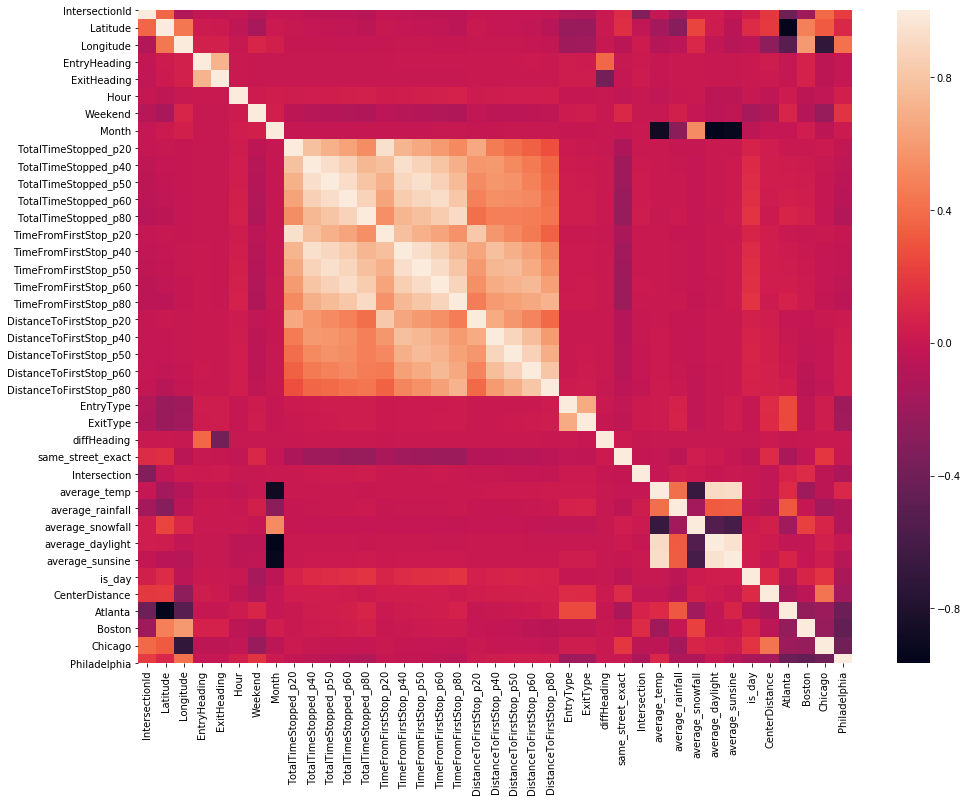

In [32]:
plt.subplots(figsize=(16,12))
sns.heatmap(train.corr(), color ='BGR4R')

In [33]:
train.corr()

,IntersectionId,Latitude,Longitude,EntryHeading,ExitHeading,Hour,Weekend,Month,TotalTimeStopped_p20,TotalTimeStopped_p40,...,average_rainfall,average_snowfall,average_daylight,average_sunsine,is_day,CenterDistance,Atlanta,Boston,Chicago,Philadelphia
IntersectionId,1.000000,0.364671,-0.097218,-0.023963,-0.029173,-0.005589,-0.075640,-0.014119,-0.015319,-0.035799,...,-0.172861,0.042252,0.034987,-0.025172,0.054955,0.186121,-0.414493,-0.188944,0.381124,0.196598
Latitude,0.364671,1.000000,0.443203,0.021309,0.016132,-0.039941,-0.150290,0.012591,-0.001065,-0.018982,...,-0.294839,0.234845,0.033493,-0.065636,0.123621,0.191364,-0.941073,0.476209,0.324386,0.096900
Longitude,-0.097218,0.443203,1.000000,0.061513,0.059625,0.001299,0.091377,0.054785,-0.011102,-0.011877,...,-0.055729,0.098287,-0.034477,-0.077178,-0.057092,-0.261773,-0.507001,0.591748,-0.703650,0.416985
EntryHeading,-0.023963,0.021309,0.061513,1.000000,0.712581,0.007046,-0.002049,0.002057,-0.000267,0.000606,...,0.004868,0.008566,-0.001366,0.000013,0.008051,0.029498,-0.010962,0.068550,-0.047071,-0.013574
ExitHeading,-0.029173,0.016132,0.059625,0.712581,1.000000,0.006430,0.000273,0.002894,-0.000083,-0.002696,...,0.006830,0.008835,-0.002263,-0.000410,0.006966,0.018169,-0.005448,0.067767,-0.049085,-0.015708
Hour,-0.005589,-0.039941,0.001299,0.007046,0.006430,1.000000,0.024931,0.046355,0.027235,0.039545,...,-0.003306,0.009397,-0.046748,-0.044737,0.002180,-0.035959,0.019333,-0.048408,-0.034537,0.050055
Weekend,-0.075640,-0.150290,0.091377,-0.002049,0.000273,0.024931,1.000000,0.050162,-0.047723,-0.076955,...,0.049897,-0.016012,-0.055375,-0.040819,-0.150598,-0.111925,0.088228,-0.081993,-0.218932,0.158986
Month,-0.014119,0.012591,0.054785,0.002057,0.002894,0.046355,0.050162,1.000000,-0.008718,-0.009679,...,-0.279948,0.526431,-0.963507,-0.931081,-0.044109,-0.015509,-0.014052,0.037530,-0.047425,0.014547
TotalTimeStopped_p20,-0.015319,-0.001065,-0.011102,-0.000267,-0.000083,0.027235,-0.047723,-0.008718,1.000000,0.781466,...,-0.006616,-0.008235,0.006729,0.010185,0.077515,0.040173,0.008534,0.008735,0.011046,-0.021796
TotalTimeStopped_p40,-0.035799,-0.018982,-0.011877,0.000606,-0.002696,0.039545,-0.076955,-0.009679,0.781466,1.000000,...,0.000021,-0.014118,0.007323,0.015325,0.115810,0.041728,0.032646,0.022650,-0.001698,-0.042505


In [34]:
train.drop(preds.columns.tolist(), axis=1, inplace =True)

In [35]:
target1 = preds['TotalTimeStopped_p20']
target2 = preds['TotalTimeStopped_p50']
target3 = preds['TotalTimeStopped_p80']
target4 = preds['DistanceToFirstStop_p20']
target5 = preds['DistanceToFirstStop_p50']
target6 = preds['DistanceToFirstStop_p80']

In [36]:
train.columns

Index(['IntersectionId', 'Latitude', 'Longitude', 'EntryHeading',
       'ExitHeading', 'Hour', 'Weekend', 'Month', 'EntryType', 'ExitType',
       'diffHeading', 'same_street_exact', 'Intersection', 'average_temp',
       'average_rainfall', 'average_snowfall', 'average_daylight',
       'average_sunsine', 'is_day', 'CenterDistance', 'Atlanta', 'Boston',
       'Chicago', 'Philadelphia'],
      dtype='object')

In [37]:
cat_feat = ['IntersectionId','Hour', 'Weekend','Month', 'same_street_exact', 'Intersection',
       'Atlanta', 'Boston', 'Chicago', 'Philadelphia', 'EntryType', 'ExitType']

In [38]:
all_preds ={0:[],1:[],2:[],3:[],4:[],5:[]}
all_target = [target1, target2, target3, target4, target5, target6]

### Reference: https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9

In [39]:
dtrain = lgb.Dataset(data=train, label=target3)

# Objective Function
def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight, lambda_l1, lambda_l2):
      
        params = {'application':'regression','num_iterations': 450,
                  'learning_rate':0.02,
                  'metric':'rmse'} # Default parameters
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
        
        cv_results = lgb.cv(params, dtrain, nfold=5, seed=17,categorical_feature=cat_feat, stratified=False,
                            verbose_eval =None)
#         print(cv_results)
        return -np.min(cv_results['rmse-mean'])

In [40]:
# Domain space-- Range of hyperparameters
pds = {'num_leaves': (120, 230),
          'feature_fraction': (0.3, 0.9),
          'bagging_fraction': (0.8, 1),
           'lambda_l1': (0,3),
           'lambda_l2': (0,5),
          'max_depth': (8, 19),
          'min_split_gain': (0.001, 0.1),
          'min_child_weight': (1, 20)
          }

In [41]:
# Surrogate model
optimizer = BayesianOptimization(hyp_lgbm,pds,random_state=7)
                                  
# Optimize
optimizer.maximize(init_points=5, n_iter=12)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Atlanta', 'Boston', 'Chicago', 'EntryType', 'ExitType', 'Hour', 'Intersection', 'IntersectionId', 'Month', 'Philadelphia', 'Weekend', 'same_street_exact']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


|  1        | -18.53    |  0.8153   |  0.768    |  1.315    |  3.617    |  18.76    |  11.23    |  0.05061  |  127.9    |
|  2        | -19.47    |  0.8537   |  0.5999   |  2.038    |  4.019    |  12.19    |  2.253    |  0.02953  |  220.1    |
|  3        | -19.07    |  0.8427   |  0.5713   |  2.794    |  0.1245   |  14.61    |  19.05    |  0.0238   |  180.3    |
|  4        | -19.75    |  0.9818   |  0.3799   |  1.57     |  3.752    |  15.36    |  9.887    |  0.02128  |  174.0    |
|  5        | -19.06    |  0.8745   |  0.5864   |  1.098    |  4.19     |  16.46    |  6.966    |  0.05769  |  150.4    |


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  6        | -21.59    |  1.0      |  0.3      |  3.0      |  0.0      |  8.0      |  1.0      |  0.1      |  120.0    |


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  7        | -20.34    |  0.9451   |  0.5241   |  2.505    |  0.4647   |  8.866    |  18.19    |  0.07665  |  186.9    |


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  8        | -20.75    |  0.8551   |  0.5204   |  1.64     |  1.55     |  8.322    |  5.223    |  0.09557  |  156.3    |


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  9        | -18.79    |  0.8225   |  0.8996   |  2.605    |  2.99     |  12.88    |  13.4     |  0.02384  |  179.5    |


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  10       | -18.45    |  0.8      |  0.8365   |  0.9444   |  4.374    |  19.0     |  12.77    |  0.03727  |  131.6    |


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  11       | -18.48    |  0.8      |  0.9      |  0.4373   |  5.0      |  19.0     |  18.68    |  0.03623  |  127.2    |


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  12       | -20.52    |  1.0      |  0.3      |  3.0      |  0.0      |  13.77    |  18.73    |  0.1      |  132.2    |


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  13       | -18.51    |  0.8      |  0.9      |  0.0      |  5.0      |  19.0     |  15.1     |  0.001    |  122.2    |


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  14       | -18.41    |  0.8      |  0.9      |  0.0      |  5.0      |  19.0     |  5.915    |  0.001    |  137.8    |


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  15       | -20.13    |  1.0      |  0.3      |  3.0      |  0.0      |  19.0     |  1.0      |  0.1      |  142.3    |


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  16       | -18.41    |  0.8      |  0.9      |  0.0      |  5.0      |  19.0     |  12.5     |  0.001    |  141.9    |


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


|  17       | -18.37    |  0.8      |  0.9      |  0.0      |  5.0      |  19.0     |  19.48    |  0.001    |  150.8    |


In [42]:
optimizer.max

{'target': -18.371558945091873,
 'params': {'bagging_fraction': 0.8,
  'feature_fraction': 0.9,
  'lambda_l1': 0.0,
  'lambda_l2': 5.0,
  'max_depth': 19.0,
  'min_child_weight': 19.481652522619488,
  'min_split_gain': 0.001,
  'num_leaves': 150.82095733403025}}

In [43]:
p = optimizer.max['params']

In [44]:
param = {'num_leaves': int(round(p['num_leaves'])),
         'feature_fraction': p['feature_fraction'],
         'bagging_fraction': p['bagging_fraction'],
         'max_depth': int(round(p['max_depth'])),
         'lambda_l1': p['lambda_l1'],
         'lambda_l2': p['lambda_l2'],
         'min_split_gain': p['min_split_gain'],
         'min_child_weight': p['min_child_weight'],
         'learning_rate':0.05,
         'objective': 'regression',
         'boosting_type': 'gbdt',
         'verbose': 1,
         'metric': 'rmse',
         'seed': 7,
        }

In [45]:
param

{'num_leaves': 151,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'max_depth': 19,
 'lambda_l1': 0.0,
 'lambda_l2': 5.0,
 'min_split_gain': 0.001,
 'min_child_weight': 19.481652522619488,
 'learning_rate': 0.05,
 'objective': 'regression',
 'boosting_type': 'gbdt',
 'verbose': 1,
 'metric': 'rmse',
 'seed': 7}

In [ ]:
%%time
nfold = 5
kf = KFold(n_splits=nfold, random_state=227, shuffle=True)
for i in range(len(all_preds)):
    print('Training and predicting for target {}'.format(i+1))
    oof = np.zeros(len(train))
    all_preds[i] = np.zeros(len(test))
    n =1
    for train_index, valid_index in kf.split(all_target[i]):
        print("fold {}".format(n))
        xg_train = lgb.Dataset(train.iloc[train_index],
                               label=all_target[i][train_index]
                               )
        xg_valid = lgb.Dataset(train.iloc[valid_index],
                               label=all_target[i][valid_index]
                               )   

        clf = lgb.train(param, xg_train, 15000, valid_sets=[xg_valid],categorical_feature=cat_feat
                        , verbose_eval=200, early_stopping_rounds=500)
        oof[valid_index] = clf.predict(train.iloc[valid_index], num_iteration=clf.best_iteration) 

        all_preds[i] += clf.predict(test, num_iteration=clf.best_iteration) / nfold
        n = n + 1

    print("\n\nCV RMSE: {:<0.4f}".format(np.sqrt(mean_squared_error(all_target[i], oof))))  

Training and predicting for target 1
fold 1


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Atlanta', 'Boston', 'Chicago', 'EntryType', 'ExitType', 'Hour', 'Intersection', 'IntersectionId', 'Month', 'Philadelphia', 'Weekend', 'same_street_exact']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[200]	valid_0's rmse: 5.68693
[400]	valid_0's rmse: 5.61609
[600]	valid_0's rmse: 5.59329
[800]	valid_0's rmse: 5.57783
[1000]	valid_0's rmse: 5.56963
[1200]	valid_0's rmse: 5.56724
[1400]	valid_0's rmse: 5.56573
[1600]	valid_0's rmse: 5.56164
[1800]	valid_0's rmse: 5.55898
[2000]	valid_0's rmse: 5.55847
[2200]	valid_0's rmse: 5.55637
[2400]	valid_0's rmse: 5.55356
[2600]	valid_0's rmse: 5.55161
[2800]	valid_0's rmse: 5.55339
[3000]	valid_0's rmse: 5.54994
[3200]	valid_0's rmse: 5.54997
[3400]	valid_0's rmse: 5.54912
[3600]	valid_0's rmse: 5.55049
Early stopping, best iteration is:
[3105]	valid_0's rmse: 5.54837
fold 2
Training until validation scores don't improve for 500 rounds.
[200]	valid_0's rmse: 5.60019
[400]	valid_0's rmse: 5.52294
[600]	valid_0's rmse: 5.49967
[800]	valid_0's rmse: 5.49389
[1000]	valid_0's rmse: 5.49362
[1200]	valid_0's rmse: 5.49068
[1400]	valid_0's rmse: 5.48801
[1600]	valid_0's rmse: 5.48534
[18

/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Atlanta', 'Boston', 'Chicago', 'EntryType', 'ExitType', 'Hour', 'Intersection', 'IntersectionId', 'Month', 'Philadelphia', 'Weekend', 'same_street_exact']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[200]	valid_0's rmse: 10.4505
[400]	valid_0's rmse: 10.0741
[600]	valid_0's rmse: 9.90904
[800]	valid_0's rmse: 9.83423
[1000]	valid_0's rmse: 9.79536
[1200]	valid_0's rmse: 9.74372
[1400]	valid_0's rmse: 9.68691
[1600]	valid_0's rmse: 9.66389
[1800]	valid_0's rmse: 9.65303
[2000]	valid_0's rmse: 9.64194
[2200]	valid_0's rmse: 9.62928
[2400]	valid_0's rmse: 9.61656
[2600]	valid_0's rmse: 9.60752
[2800]	valid_0's rmse: 9.59675
[3000]	valid_0's rmse: 9.59427
[3200]	valid_0's rmse: 9.59135
[3400]	valid_0's rmse: 9.59207
[3600]	valid_0's rmse: 9.59075
[3800]	valid_0's rmse: 9.58803
[4000]	valid_0's rmse: 9.58667
[4200]	valid_0's rmse: 9.58526
[4400]	valid_0's rmse: 9.58491
[4600]	valid_0's rmse: 9.58364
[4800]	valid_0's rmse: 9.58148
[5000]	valid_0's rmse: 9.58044
[5200]	valid_0's rmse: 9.58074
[5400]	valid_0's rmse: 9.58131
[5600]	valid_0's rmse: 9.58211
[5800]	valid_0's rmse: 9.58073
Early stopping, best iteration is:
[5304]	

/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Atlanta', 'Boston', 'Chicago', 'EntryType', 'ExitType', 'Hour', 'Intersection', 'IntersectionId', 'Month', 'Philadelphia', 'Weekend', 'same_street_exact']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[200]	valid_0's rmse: 18.3266
[400]	valid_0's rmse: 17.4526
[600]	valid_0's rmse: 17.097
[800]	valid_0's rmse: 16.8642
[1000]	valid_0's rmse: 16.7856
[1200]	valid_0's rmse: 16.6722
[1400]	valid_0's rmse: 16.6211
[1600]	valid_0's rmse: 16.5806
[1800]	valid_0's rmse: 16.5387
[2000]	valid_0's rmse: 16.5147
[2200]	valid_0's rmse: 16.4908
[2400]	valid_0's rmse: 16.4757
[2600]	valid_0's rmse: 16.4535
[2800]	valid_0's rmse: 16.4457
[3000]	valid_0's rmse: 16.4331
[3200]	valid_0's rmse: 16.4185
[3400]	valid_0's rmse: 16.3989
[3600]	valid_0's rmse: 16.3919
[3800]	valid_0's rmse: 16.3907
[4000]	valid_0's rmse: 16.3851
[4200]	valid_0's rmse: 16.3838
[4400]	valid_0's rmse: 16.3826
[4600]	valid_0's rmse: 16.3801
[4800]	valid_0's rmse: 16.3776
[5000]	valid_0's rmse: 16.3726
[5200]	valid_0's rmse: 16.3721
[5400]	valid_0's rmse: 16.3743
Early stopping, best iteration is:
[5032]	valid_0's rmse: 16.371
fold 2
Training until validation scores 

In [ ]:
data2 = pd.DataFrame(all_preds).stack()
data2 = pd.DataFrame(data2)
submission['Target'] = data2[0].values

In [ ]:
submission.head(15)

In [ ]:
submission.to_csv('submission.csv', index=False)

<center><span style='color:blue;background:yellow;font-size:30px'>**Please upvote this notebook if you like my work. **

**References:**
1. https://www.kaggle.com/whatust/fork-of-kernel56e53f4445
2. https://www.kaggle.com/brokenfulcrum/geotab-baseline
3. https://www.kaggle.com/danofer/baseline-feature-engineering-geotab-69-5-lb
4.  https://www.kaggle.com/bgmello/how-one-percentile-affect-the-others